## **Импорты**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

## **Границы**

In [3]:
rng = 5

a = -rng
b = rng
prec = 0.01

## **Отрисовка**

In [4]:
def ShowFunc(func , name):
  plt.figure(figsize=(20,4))
  plt.title(name)
  arr= [func(i) for i in np.arange(a,b,prec) ]
  axis = np.arange(a,b,prec) 
  plt.plot( axis , arr,'r-')
  plt.grid(True)
  plt.show()

def ShowArr(arr , name):
  plt.figure(figsize=(20,4))
  plt.title(name)
  axis = np.arange(a,b,prec) 
  plt.plot( axis , arr,'r-')
  plt.grid(True)
  plt.show()

def ShowFourier(arr, name):
  plt.figure(figsize=(20,4))
  plt.title(name)
  axis = [i*1/prec/len(arr) for i in range(len(arr))]
  plt.xlim (0, np.max(axis)/2)
  plt.plot( axis , arr,'r-')
  plt.grid(True)
  plt.show()


## **Свертка**

In [5]:
def convol(func1 , func2):
  conv = np.convolve(func1 ,func2)
  a1 = abs(round(a/prec))
  b1 = abs(round((b-a)/prec)) + abs(round(a/prec))
  return conv[a1:b1]

## **Оригинал фильтра**

In [6]:
def rect(w1,w2):
  return lambda x: 1 if w1<x and x<w2 else 0

def filter(w1,w2):
  fil = np.fft.ifft([rect(w1,w2)(i) for i in np.arange(0,b-a,prec)])
  tmp = np.split(fil, 2)  
  return np.concatenate([tmp[1], tmp[0]])

## **Функция для тестов**

In [12]:
def Test(func,a1,b1): 
  a1 = a1/50*rng
  b1 = b1/50*rng 
  fil = filter(a1,b1)
  ShowArr(fil ,"fil")
  four_sign = np.fft.fft([func(i) for i in np.arange(a,b,prec)])
  ShowFourier(abs(four_sign),"func fourier")
  rect_sign = [rect(a1,b1)(i) for i in np.arange(0,b-a,prec)]
  ShowFourier(rect_sign ,"rect fourier")
  func_res = [func(i) for i in np.arange(a,b,prec) ]
  ShowArr(func_res,"before filter")
  ShowArr(convol(func_res , fil),"after filter")

## **Тесты**

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


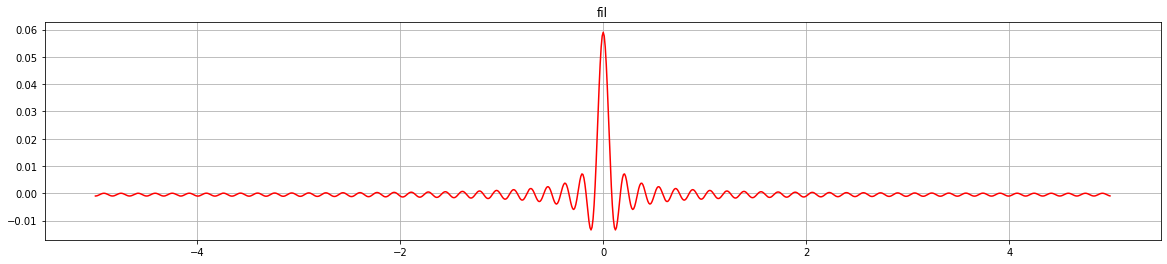

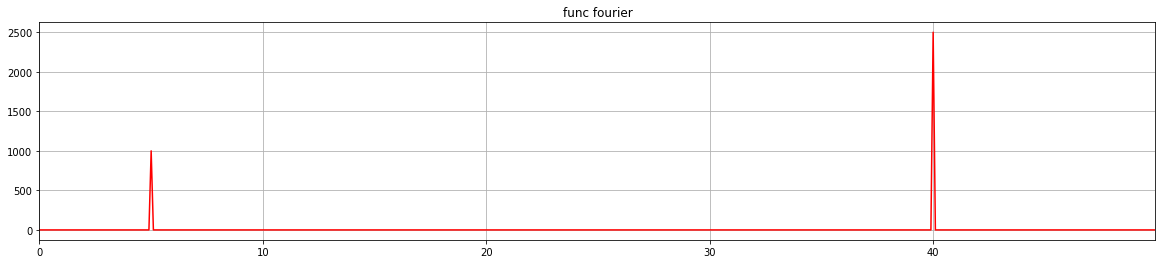

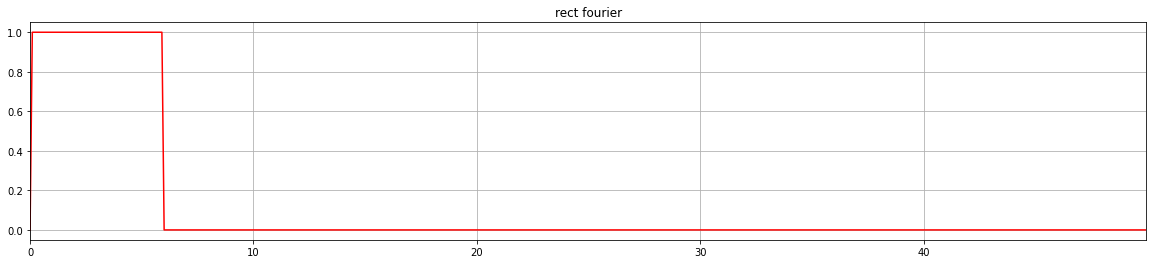

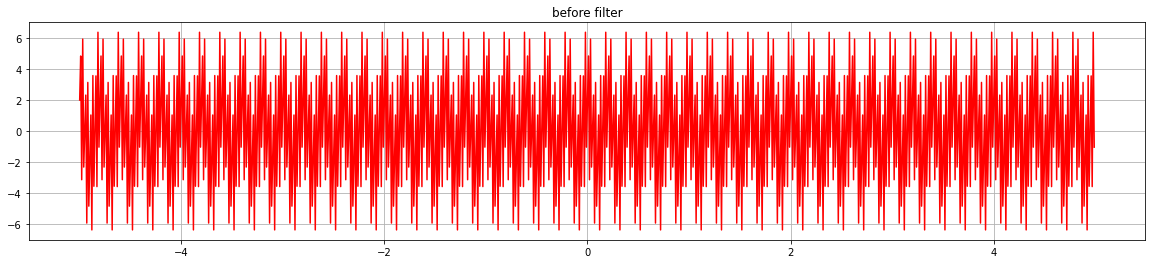

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


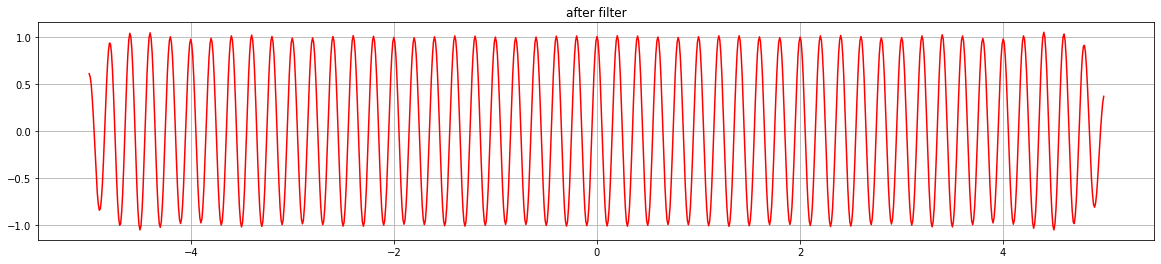

In [14]:
def cos_sin(a1,a2,w1,w2):
  return lambda x: a1*np.cos(w1*x*np.pi*2) + a2*np.sin(w2*x*np.pi*2)
Test(cos_sin(2,5,5,40) ,0,6)